## 房价预测demo1：特征工程+模型融合

### 1. 预处理

In [1]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 实例化处理数字型特征的缺失值的变换器
numerical_transformer1 = SimpleImputer(strategy='mean')
numerical_transformer2 = SimpleImputer(strategy='most_frequent')
# 实例化处理年份特征的变换器
year_transformer = LabelEncoder()

In [2]:
# 读取原始数据
X_train_full = pd.read_csv('train.csv', index_col='Id')
X_test_full = pd.read_csv('test.csv', index_col='Id')
# y_train_full是训练集+验证集的目标变量列
y_train_full = X_train_full.SalePrice
X_train_full.drop(['SalePrice'], axis=1, inplace=True)
# X_full是训练集+测试集，前1460行是训练集
X_full = pd.concat([X_train_full, X_test_full], axis = 0)

# 选出数字型特征的列
numerical_cols = [cname for cname in X_full.columns if X_full[cname].dtype in ['int64', 'float64']]
# 这里原始数据集把OverallQual,OverallCond归为了数值型，但实际上它们是类别型
# 同时将时序属性从数字属性组中删去
numerical_cols.remove('OverallQual')
numerical_cols.remove('OverallCond')
numerical_cols.remove('YearBuilt')
numerical_cols.remove('YearRemodAdd')
numerical_cols.remove('GarageYrBlt')
numerical_cols.remove('MoSold')
numerical_cols.remove('YrSold')

# 均值填充
X_full[numerical_cols] = numerical_transformer1.fit_transform(X_full[numerical_cols]).round().astype('int64')
# 在时序属性中，只有GarageYrBlt含缺失值，对其进行众数填充
X_full['GarageYrBlt'] = numerical_transformer2.fit_transform(X_full['GarageYrBlt'].values.reshape(-1, 1))
# 再对类别型特征进行factorize编码（NAN值编码为-1）
object_cols = [cname for cname in X_full.columns if X_full[cname].dtype == 'object']
for colname in object_cols:
    X_full[colname], _ = X_full[colname].factorize()
    
# object属性组（非int/float型属性）
object_cols = object_cols + ['OverallQual', 'OverallCond']
# 时序属性组
time_cols =['YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold']

### 2. 特征工程——Mutual Information

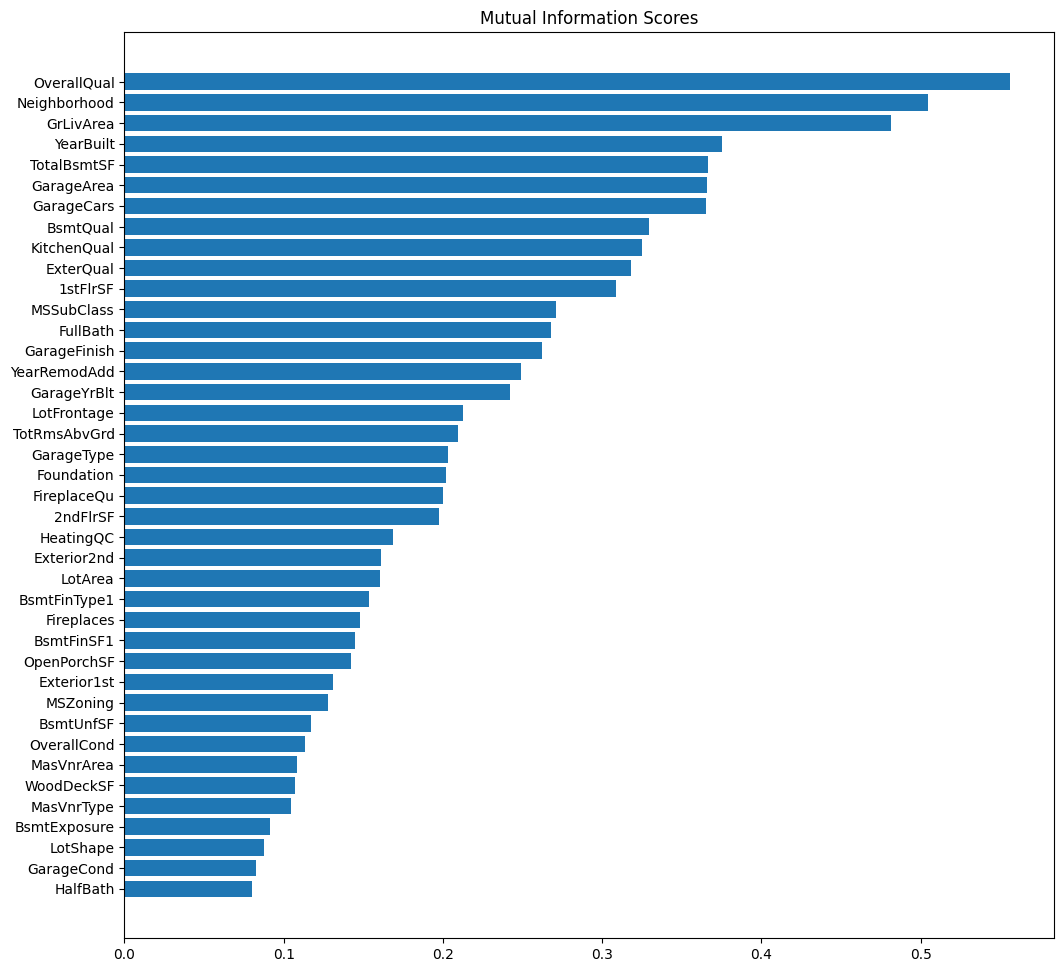

In [3]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# 计算所有特征与price之间的互信息，降序排列
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# 互信息值降序排列可视化
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# # 计算训练集特征和price间的互信息
mi_scores = make_mi_scores(X_full[:1460], y_train_full, X_full[:1460].dtypes == int)
plt.figure(dpi=100, figsize=(12, 12))
plot_mi_scores(mi_scores[:40])

<AxesSubplot:xlabel='GarageFinish', ylabel='SalePrice'>

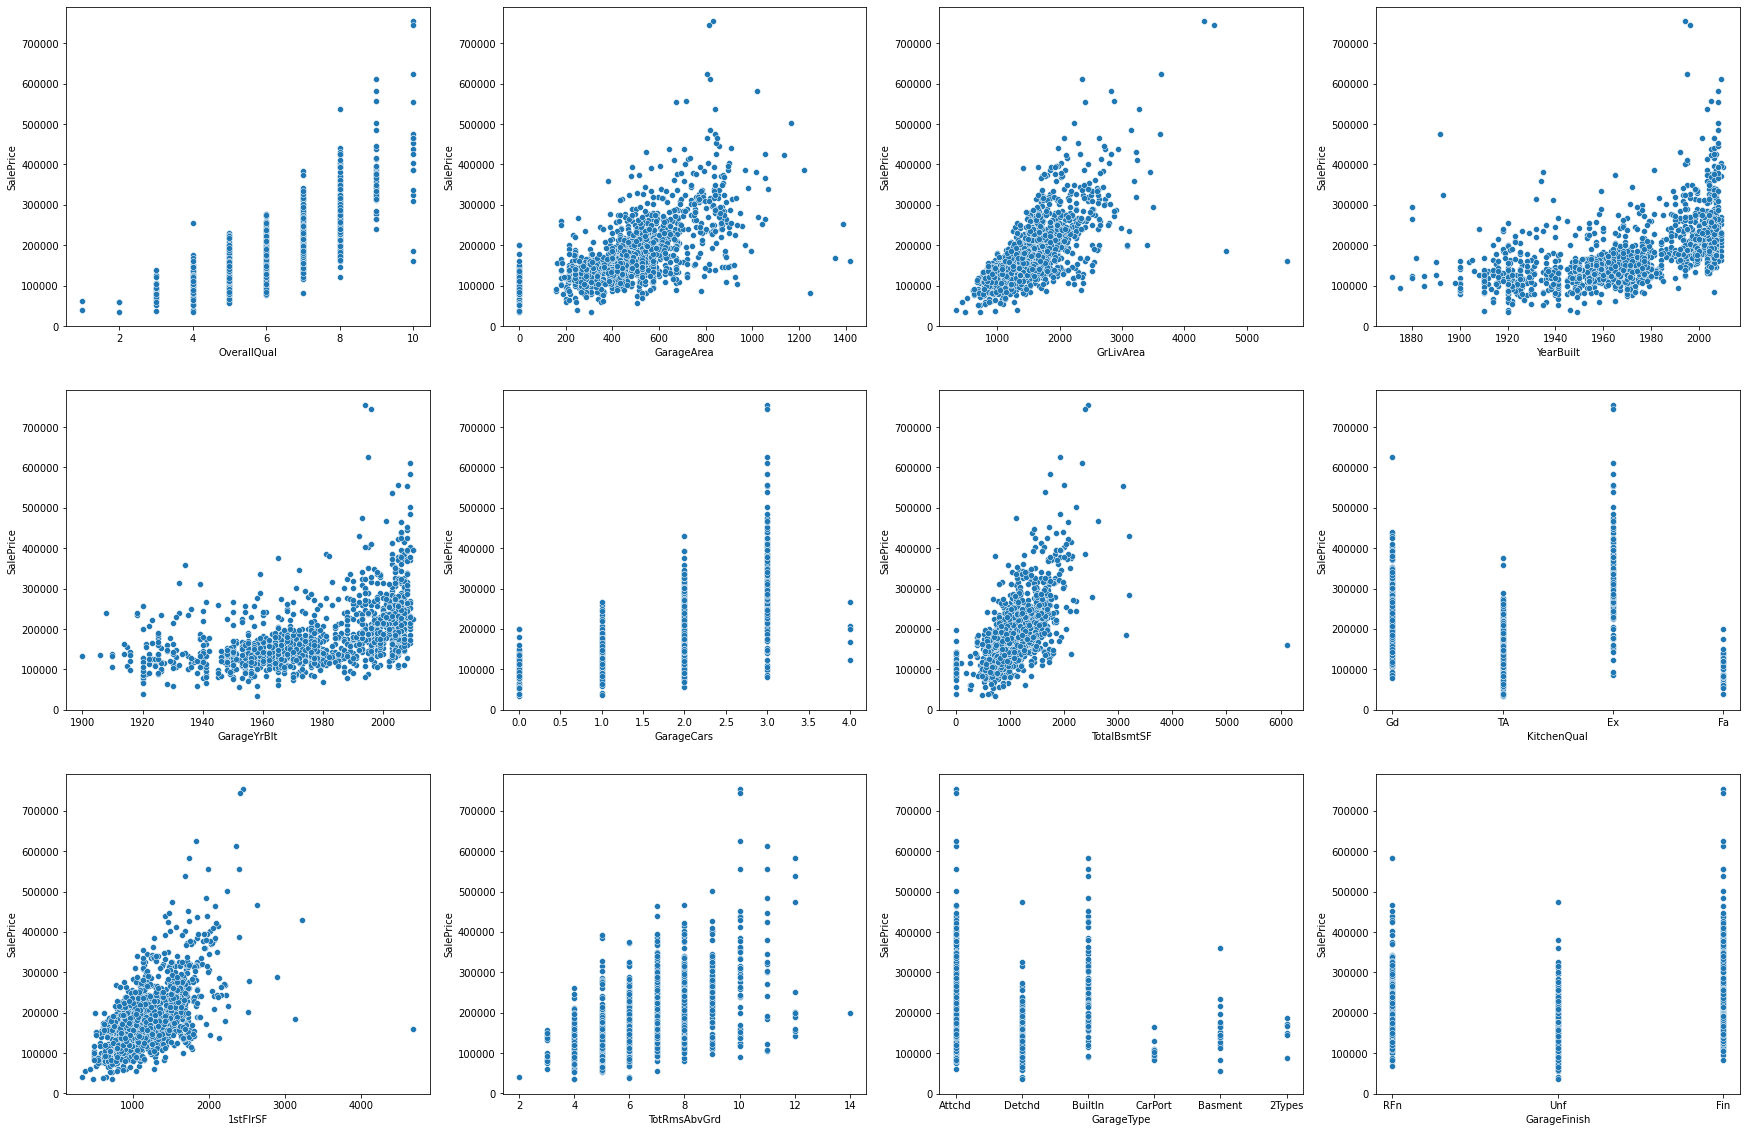

In [4]:
# 绘制高相关特征和price的散点图
import seaborn as sns
import matplotlib.pyplot as plt

Xy = pd.read_csv('train.csv', index_col='Id')
fig, ax_arr = plt.subplots(3,4, figsize=(30,20))
sns.scatterplot(x="OverallQual", y="SalePrice", data=Xy, ax=ax_arr[0][0])
sns.scatterplot(x="GarageArea", y="SalePrice", data=Xy, ax= ax_arr[0][1])
sns.scatterplot(x="GrLivArea", y="SalePrice", data=Xy, ax=ax_arr[0][2])
sns.scatterplot(x="YearBuilt", y="SalePrice", data=Xy, ax=ax_arr[0][3])
sns.scatterplot(x="GarageYrBlt", y="SalePrice", data=Xy, ax=ax_arr[1][0])
sns.scatterplot(x="GarageCars", y="SalePrice", data=Xy, ax=ax_arr[1][1])
sns.scatterplot(x="TotalBsmtSF", y="SalePrice", data=Xy, ax=ax_arr[1][2])
sns.scatterplot(x="KitchenQual", y="SalePrice", data=Xy, ax=ax_arr[1][3])
sns.scatterplot(x="1stFlrSF", y="SalePrice", data=Xy, ax=ax_arr[2][0])
sns.scatterplot(x="TotRmsAbvGrd", y="SalePrice", data=Xy, ax=ax_arr[2][1])
sns.scatterplot(x="GarageType", y="SalePrice", data=Xy, ax=ax_arr[2][2])
sns.scatterplot(x="GarageFinish", y="SalePrice", data=Xy, ax=ax_arr[2][3])

### 3. 根据MI排名前几的特征剔除若干离群点

In [5]:
# 这里用Xy找离群点的行索引（因为要用到price列），然后在我们的X_full中去除这些离群点所在的行
# Xy[逻辑表达式]返回的是表格中的一行数据
ol_1 = Xy[(Xy['OverallQual'] == 4) & (Xy['SalePrice'] > 200000)].index.tolist()
ol_2 = Xy[(Xy['OverallQual'] == 8) & (Xy['SalePrice'] > 500000)].index.tolist()
ol_3 = Xy[(Xy['GarageArea'] > 1200) & (Xy['SalePrice'] < 300000)].index.tolist()
ol_4 = Xy[(Xy['GarageArea'] > 800) & (Xy['SalePrice'] > 700000)].index.tolist()
ol_5 = Xy[(Xy['GrLivArea'] > 4000) & (Xy['SalePrice'] < 200000)].index.tolist()
ol_6 = Xy[(Xy['YearBuilt'] < 1900) & (Xy['SalePrice'] > 400000)].index.tolist()
ol_7 = Xy[(Xy['GarageYrBlt'] < 2000) & (Xy['SalePrice'] > 700000)].index.tolist()
ol_8 = Xy[(Xy['GarageCars'] == 3) & (Xy['SalePrice'] > 700000)].index.tolist()
ol_9 = Xy[(Xy['TotalBsmtSF'] > 6000) & (Xy['SalePrice'] < 200000)].index.tolist()
ol_10 = Xy[(Xy['LotArea'] > 150000) & (Xy['SalePrice'] < 400000)].index.tolist()
ol_11 = Xy[(Xy['KitchenQual'] == 'Gd') & (Xy['SalePrice'] > 600000)].index.tolist()
ol_12 = Xy[(Xy['1stFlrSF'] > 4000) & (Xy['SalePrice'] < 200000)].index.tolist()
ol_13 = Xy[(Xy['LotFrontage'] > 300) & (Xy['SalePrice'] < 300000)].index.tolist()
ol_14 = Xy[(Xy['GarageFinish'] == 'RFn') & (Xy['SalePrice'] > 500000)].index.tolist()

ols = ol_1 + ol_2 + ol_3 + ol_4 + ol_5 + ol_6 + ol_7 + ol_8 + ol_9 + ol_10 + ol_11 + ol_12 + ol_13 + ol_14
ols = list(set(ols))
print('离群点个数: {}，索引: {}'.format(len(ols), ols))

# 特征矩阵以及标签都需要删除
X_full.drop(index=ols, inplace=True)
y_train_full.drop(index=ols, inplace=True)
print('离群点已剔除')

# 重置索引
X_full.reset_index(drop=True, inplace=True)
y_train_full.reset_index(drop=True, inplace=True)

# 现在X_full前1444行是训练集

离群点个数: 16，索引: [770, 804, 1062, 582, 1191, 935, 458, 250, 524, 314, 336, 1170, 1299, 692, 186, 1183]
离群点已剔除


### 4. 构造新特征
#### 4.1. 根据特征的实际意义进行深层语义的特征构建
借鉴知乎博主 @陈罐头

In [6]:
X_full['TotalSF'] = X_full['TotalBsmtSF'] + X_full['1stFlrSF'] + X_full['2ndFlrSF']
X_full['YrSinceRemod'] = X_full['YrSold'].astype(int) - X_full['YearRemodAdd'].astype(int)
X_full['YrSinceBuilt'] = X_full['YrSold'].astype(int) - X_full['YearBuilt'].astype(int)
X_full['OverallEval'] = X_full['OverallQual'] + X_full['OverallCond']
X_full['LowQualPct'] = X_full['LowQualFinSF'] / X_full['TotalSF']
X_full['funcSF'] = X_full['WoodDeckSF'] + X_full['OpenPorchSF'] + X_full['EnclosedPorch'] + X_full['3SsnPorch'] + X_full['ScreenPorch'] + X_full['PoolArea']
manual_added_features = ['TotalSF', 'YrSinceRemod', 'YrSinceBuilt', 'OverallEval', 'LowQualPct', 'funcSF']

#### 4.2. K-Means聚类
In the context of feature engineering for prediction, you could think of an unsupervised algorithm as a "feature discovery" technique.

In [7]:
from sklearn.cluster import KMeans

# 选择参与聚类的特征（和目标变量高相关的且特征间相关性较低）
features = ['Neighborhood', 'OverallQual', 'GarageCars', 'GarageYrBlt', 'YrSinceBuilt', 'GrLivArea', 'LotArea', 'TotalSF']

# 标准化
X_scaled = X_full.loc[:, features[5:]]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

# 生成kmeans模型
kmeans = KMeans(n_clusters=8, random_state=0)
# 生成类别特征
X_full["Cluster"] = kmeans.fit_predict(pd.concat([X_full[features[:5]], X_scaled], axis=1))
# 生成类别距离特征
X_cd = kmeans.fit_transform(X_scaled)
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X_full = X_full.join(X_cd)

#### 绘制若干特征与price间由聚类结果分割的散点图

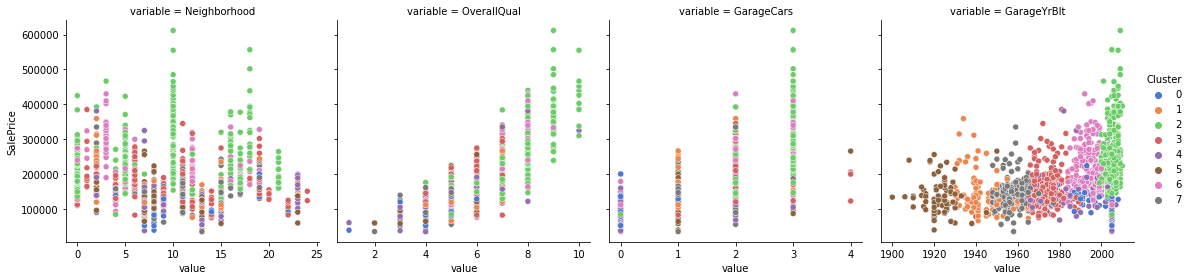

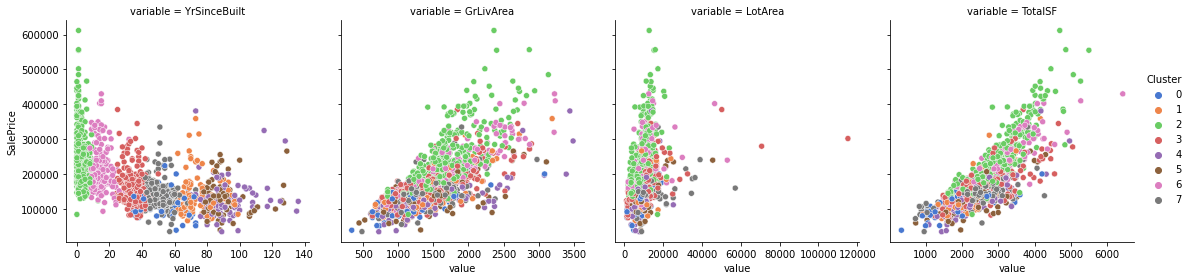

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

X_train_full_temp = X_full[:1444].copy()
X_train_full_temp['SalePrice'] = y_train_full
# 先画前4个图
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, palette='muted',
    data=X_train_full_temp.melt(
        value_vars=features[:4],
        id_vars=["SalePrice", "Cluster"]
    )
)

# 再画后4个图
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, palette='muted',
    data=X_train_full_temp.melt(
        value_vars=features[4:],
        id_vars=["SalePrice", "Cluster"]
    )
)

# 最后把price列删去
X_train_full_temp.drop(['SalePrice'], axis=1, inplace=True)

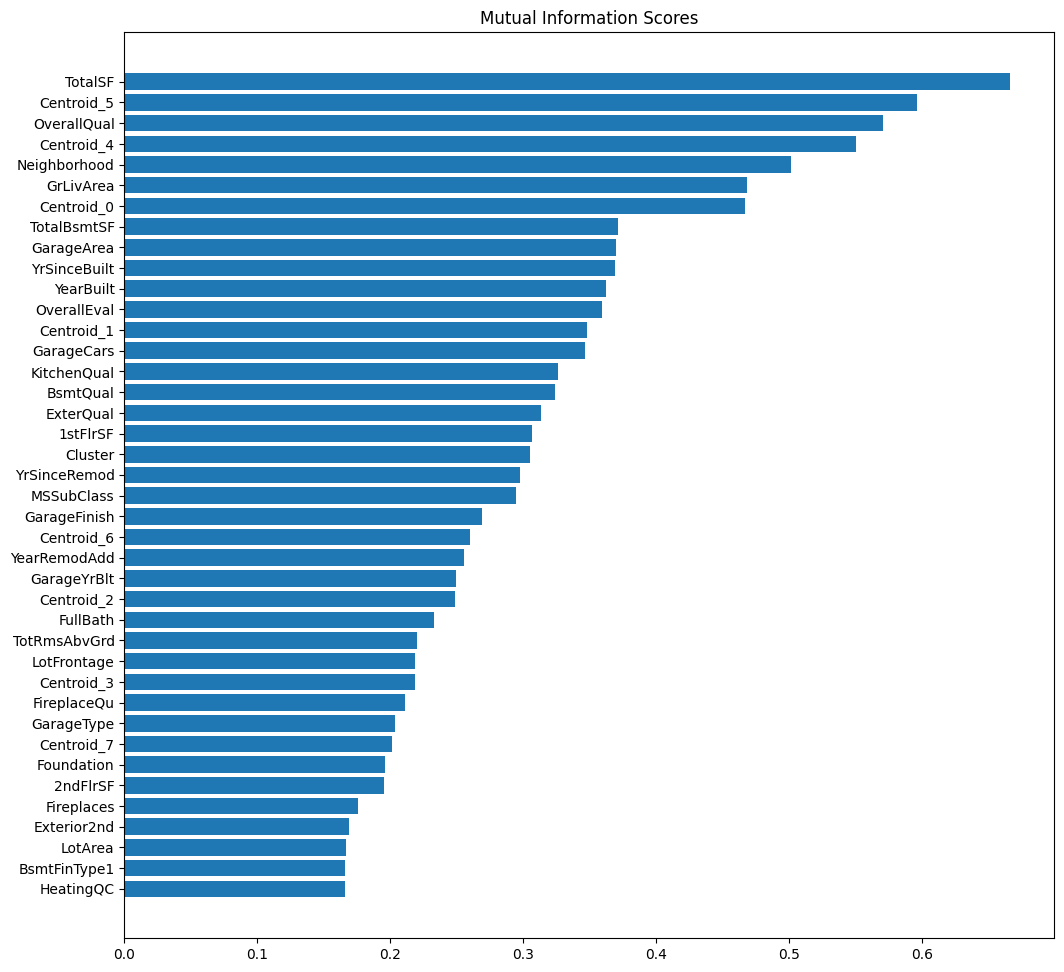

In [10]:
# 计算训练集特征和price间的互信息
mi_scores = make_mi_scores(X_full[:1444], y_train_full, X_full[:1444].dtypes == int)
plt.figure(dpi=100, figsize=(12, 12))
plot_mi_scores(mi_scores[:40])
# 计算训练集特征和price间的互信息 证明了新增的特征Cluster和因变量的互信息仍在前列

#### 4.3. PCA构造主成分作为新特征

In [11]:
from sklearn.decomposition import PCA

# 选择参与聚类的特征
#features = ['Neighborhood', 'OverallQual', 'GarageCars', 'GarageYrBlt', 'YrSinceBuilt', 'GrLivArea', 'LotArea', 'TotalSF']
# 只有数字型特征才需要标准化
X_scaled = X_full.loc[:, numerical_cols]

# 标准化
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

# 实例化PCA器
pca = PCA(n_components=0.98) # 保证降维后的数据保持97%的信息
X_pca = pca.fit_transform(pd.concat([X_full[object_cols], X_full[time_cols], X_full[features[:5]], X_scaled], axis=1))

# 构造主成分列名，放在列表中
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
# 将8个主成分构造为一张新表
X_pca = pd.DataFrame(X_pca, columns=component_names)
# 合并到X_train_full中
X_full = pd.concat([X_full, X_pca], axis = 1)

Index(['TotalSF', 'Centroid_5', 'OverallQual', 'Centroid_4', 'Neighborhood',
       'GrLivArea', 'Centroid_0', 'PC4', 'YrSinceBuilt', 'TotalBsmtSF',
       'GarageArea', 'YearBuilt', 'GarageCars', 'OverallEval', 'Centroid_1',
       'PC1', 'BsmtQual', 'ExterQual', 'KitchenQual', 'PC3', '1stFlrSF',
       'Cluster', 'YrSinceRemod', 'PC2', 'MSSubClass', 'GarageFinish',
       'GarageYrBlt', 'YearRemodAdd', 'Centroid_6', 'Centroid_2', 'FullBath',
       'Centroid_3', 'LotFrontage', 'FireplaceQu', 'TotRmsAbvGrd',
       'GarageType', '2ndFlrSF', 'Centroid_7', 'Foundation', 'Exterior2nd',
       'LotArea', 'HeatingQC', 'BsmtFinType1', 'Fireplaces', 'OpenPorchSF',
       'BsmtFinSF1', 'Exterior1st', 'funcSF', 'OverallCond', 'BsmtUnfSF',
       'MSZoning', 'MasVnrType', 'WoodDeckSF', 'MasVnrArea', 'HouseStyle',
       'SaleType', 'SaleCondition', 'GarageQual', 'GarageCond', 'BedroomAbvGr',
       'HalfBath', 'BsmtExposure', 'LotShape', 'CentralAir', 'Electrical',
       'BldgType', 'Fence', '

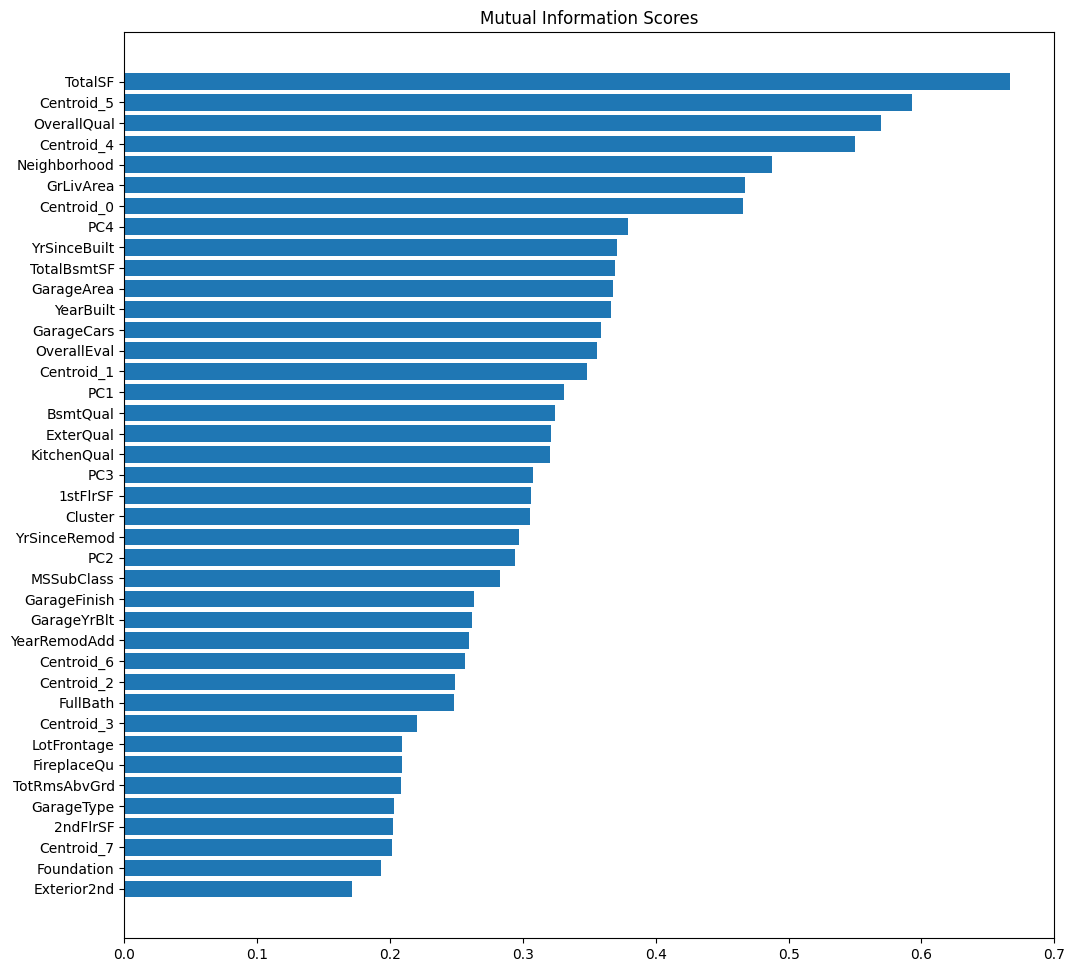

In [12]:
# 计算目前的特征和price间的互信息
mi_scores = make_mi_scores(X_full[:1444], y_train_full, X_full[:1444].dtypes == int)
plt.figure(dpi=100, figsize=(12, 12))
plot_mi_scores(mi_scores[:40])

# 调出排名靠前的特征构造新特征
top_mi_features = list(mi_scores[:].index)
selected_features = top_mi_features
X_full = X_full[selected_features]
print(X_full.columns, len(X_full.columns.tolist()))

和我们期望的一样：MI值最高的OverallQual特征确实和price之间存在很强的关系  
特征的互信息值越高，表示我们用该特征预测出目标变量的信心越大  
换言之，当我们知道OverallQual后，我们对于price的不确定性（熵）会减小

### 5. 特征工程——特征相关热力图（剔除共线性而相对不重要的特征）

<AxesSubplot:>

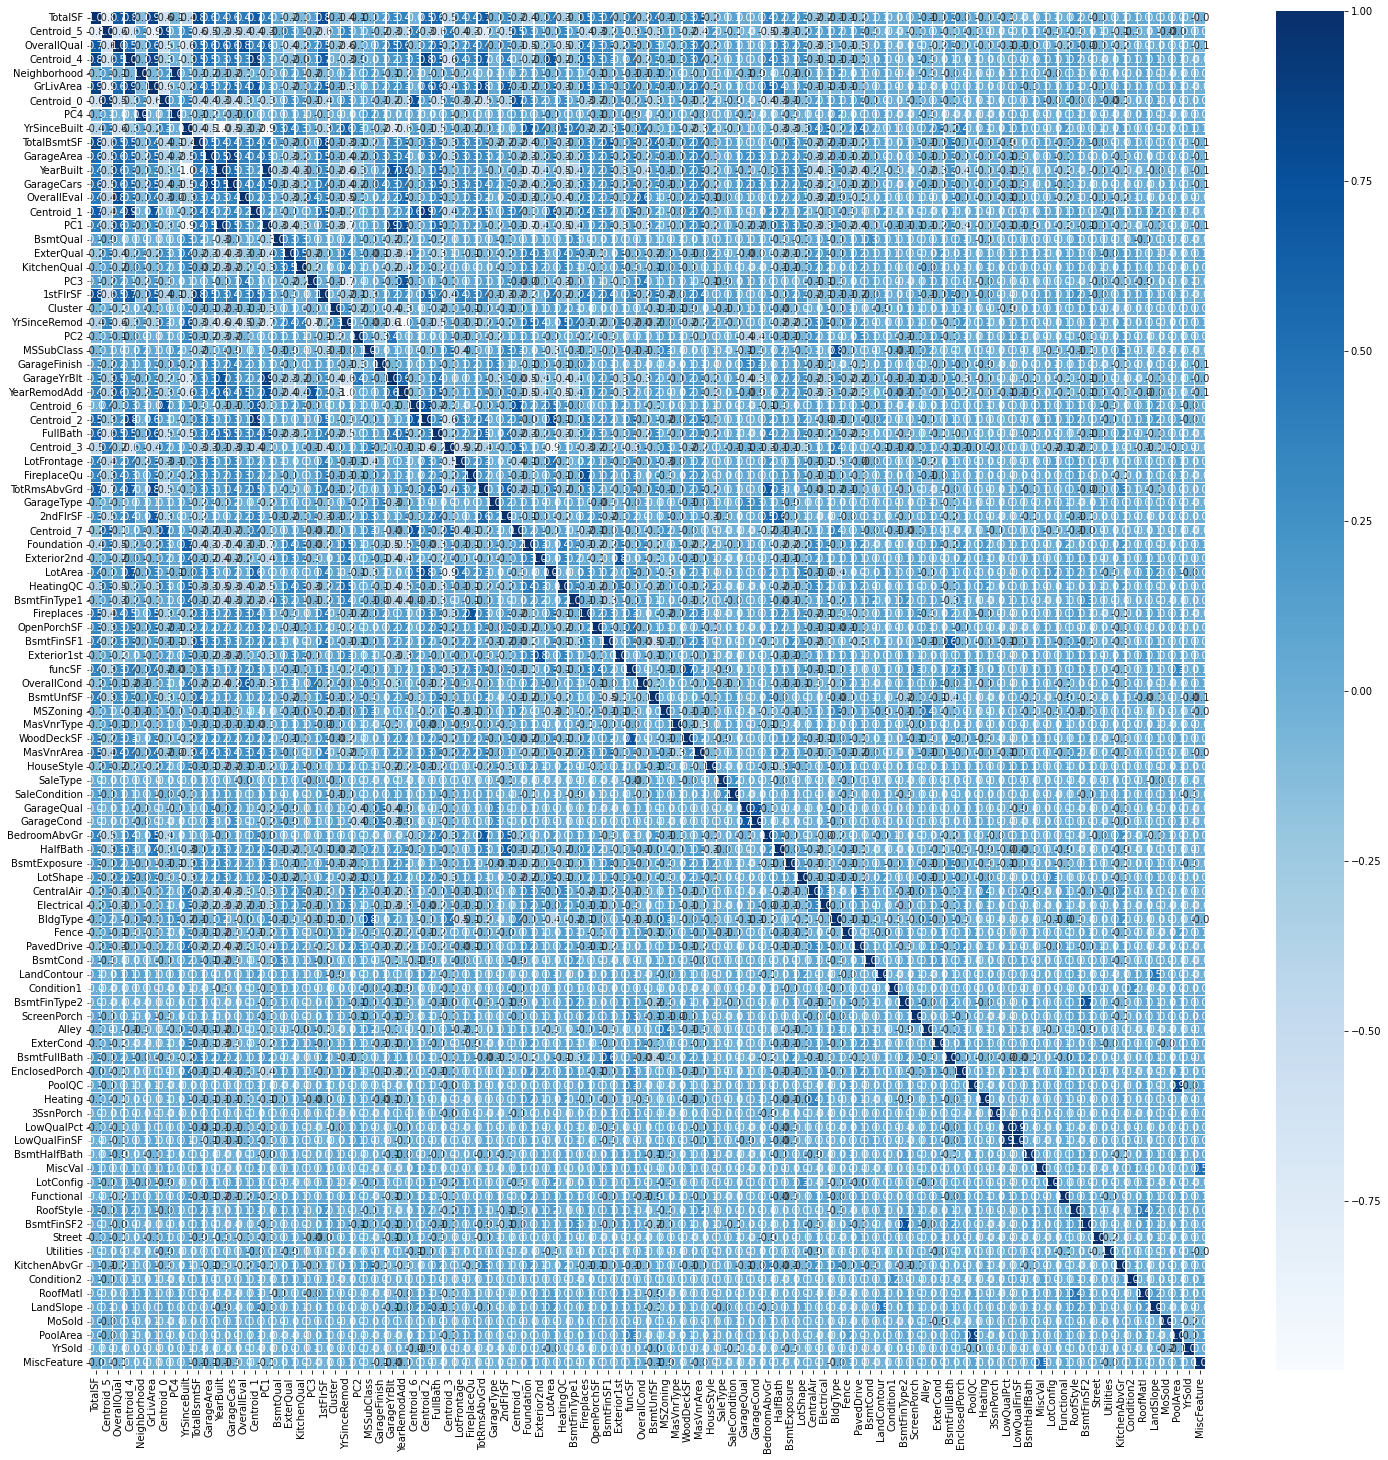

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

f,ax = plt.subplots(figsize=(25, 25))
sns.heatmap(X_full.corr(), annot=True, linewidths=.5, fmt= '.1f', ax=ax, cmap='Blues')

### 6. 特征工程——Permutation Importance（进一步剔除冗余特征）

一个特征的Permutation Importance用“将该特征的值用随机数代替后对于模型预测准确率的影响”来表示  
保持其他特征值不变，将该特征的值随机替换后模型预测准确率下降得越大，则侧面说明该特征对于正确预测出目标变量越重要

In [14]:
# 临时构造一个模型用于计算PI
from lightgbm import LGBMRegressor

# 临时划分数据集用于计算PI
X_train_full = X_full[:1444].copy()
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=1)

model = LGBMRegressor(objective='regression',
                          n_estimators=1000,
                          learning_rate = 0.01,
                          max_depth=5,
                          num_leaves=30,
                          min_data_in_leaf=3,
                          max_bin=25,
                          bagging_fraction=0.6,
                          bagging_freq=11,
                          feature_fraction=0.6,
                          lambda_l1=0.004641588833612777,
                          lambda_l2=4.641588833612782e-05,
                          verbose=-1,
                          n_jobs=-1,
                          random_state=0).fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] lambda_l1 is set=0.004641588833612777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004641588833612777
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=4.641588833612782e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.641588833612782e-05
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11


### Permutation Importance降序排列图

In [15]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())

### 7. 特征工程——结合共线性、Permutation Importance剔除特征

In [16]:
# 缺失值占比80%以上的特征已在互信息模块被恰好消除
# 下面的坏特征是根据共线性和PI选择的
bad_features = ['WoodDeckSF','TotRmsAbvGrd','GarageYrBlt','GarageArea','Fireplaces','TotalBsmtSF','1stFlrSF','2ndFlrSF']

selected_features_1 = selected_features.copy()
for feature in bad_features:
    if feature in selected_features_1:
        selected_features_1.remove(feature)
# 打印筛选后的特征
print(len(selected_features_1), selected_features_1)
X_full = X_full[selected_features_1]

90 ['TotalSF', 'Centroid_5', 'OverallQual', 'Centroid_4', 'Neighborhood', 'GrLivArea', 'Centroid_0', 'PC4', 'YrSinceBuilt', 'YearBuilt', 'GarageCars', 'OverallEval', 'Centroid_1', 'PC1', 'BsmtQual', 'ExterQual', 'KitchenQual', 'PC3', 'Cluster', 'YrSinceRemod', 'PC2', 'MSSubClass', 'GarageFinish', 'YearRemodAdd', 'Centroid_6', 'Centroid_2', 'FullBath', 'Centroid_3', 'LotFrontage', 'FireplaceQu', 'GarageType', 'Centroid_7', 'Foundation', 'Exterior2nd', 'LotArea', 'HeatingQC', 'BsmtFinType1', 'OpenPorchSF', 'BsmtFinSF1', 'Exterior1st', 'funcSF', 'OverallCond', 'BsmtUnfSF', 'MSZoning', 'MasVnrType', 'MasVnrArea', 'HouseStyle', 'SaleType', 'SaleCondition', 'GarageQual', 'GarageCond', 'BedroomAbvGr', 'HalfBath', 'BsmtExposure', 'LotShape', 'CentralAir', 'Electrical', 'BldgType', 'Fence', 'PavedDrive', 'BsmtCond', 'LandContour', 'Condition1', 'BsmtFinType2', 'ScreenPorch', 'Alley', 'ExterCond', 'BsmtFullBath', 'EnclosedPorch', 'PoolQC', 'Heating', '3SsnPorch', 'LowQualPct', 'LowQualFinSF', 'B

<AxesSubplot:>

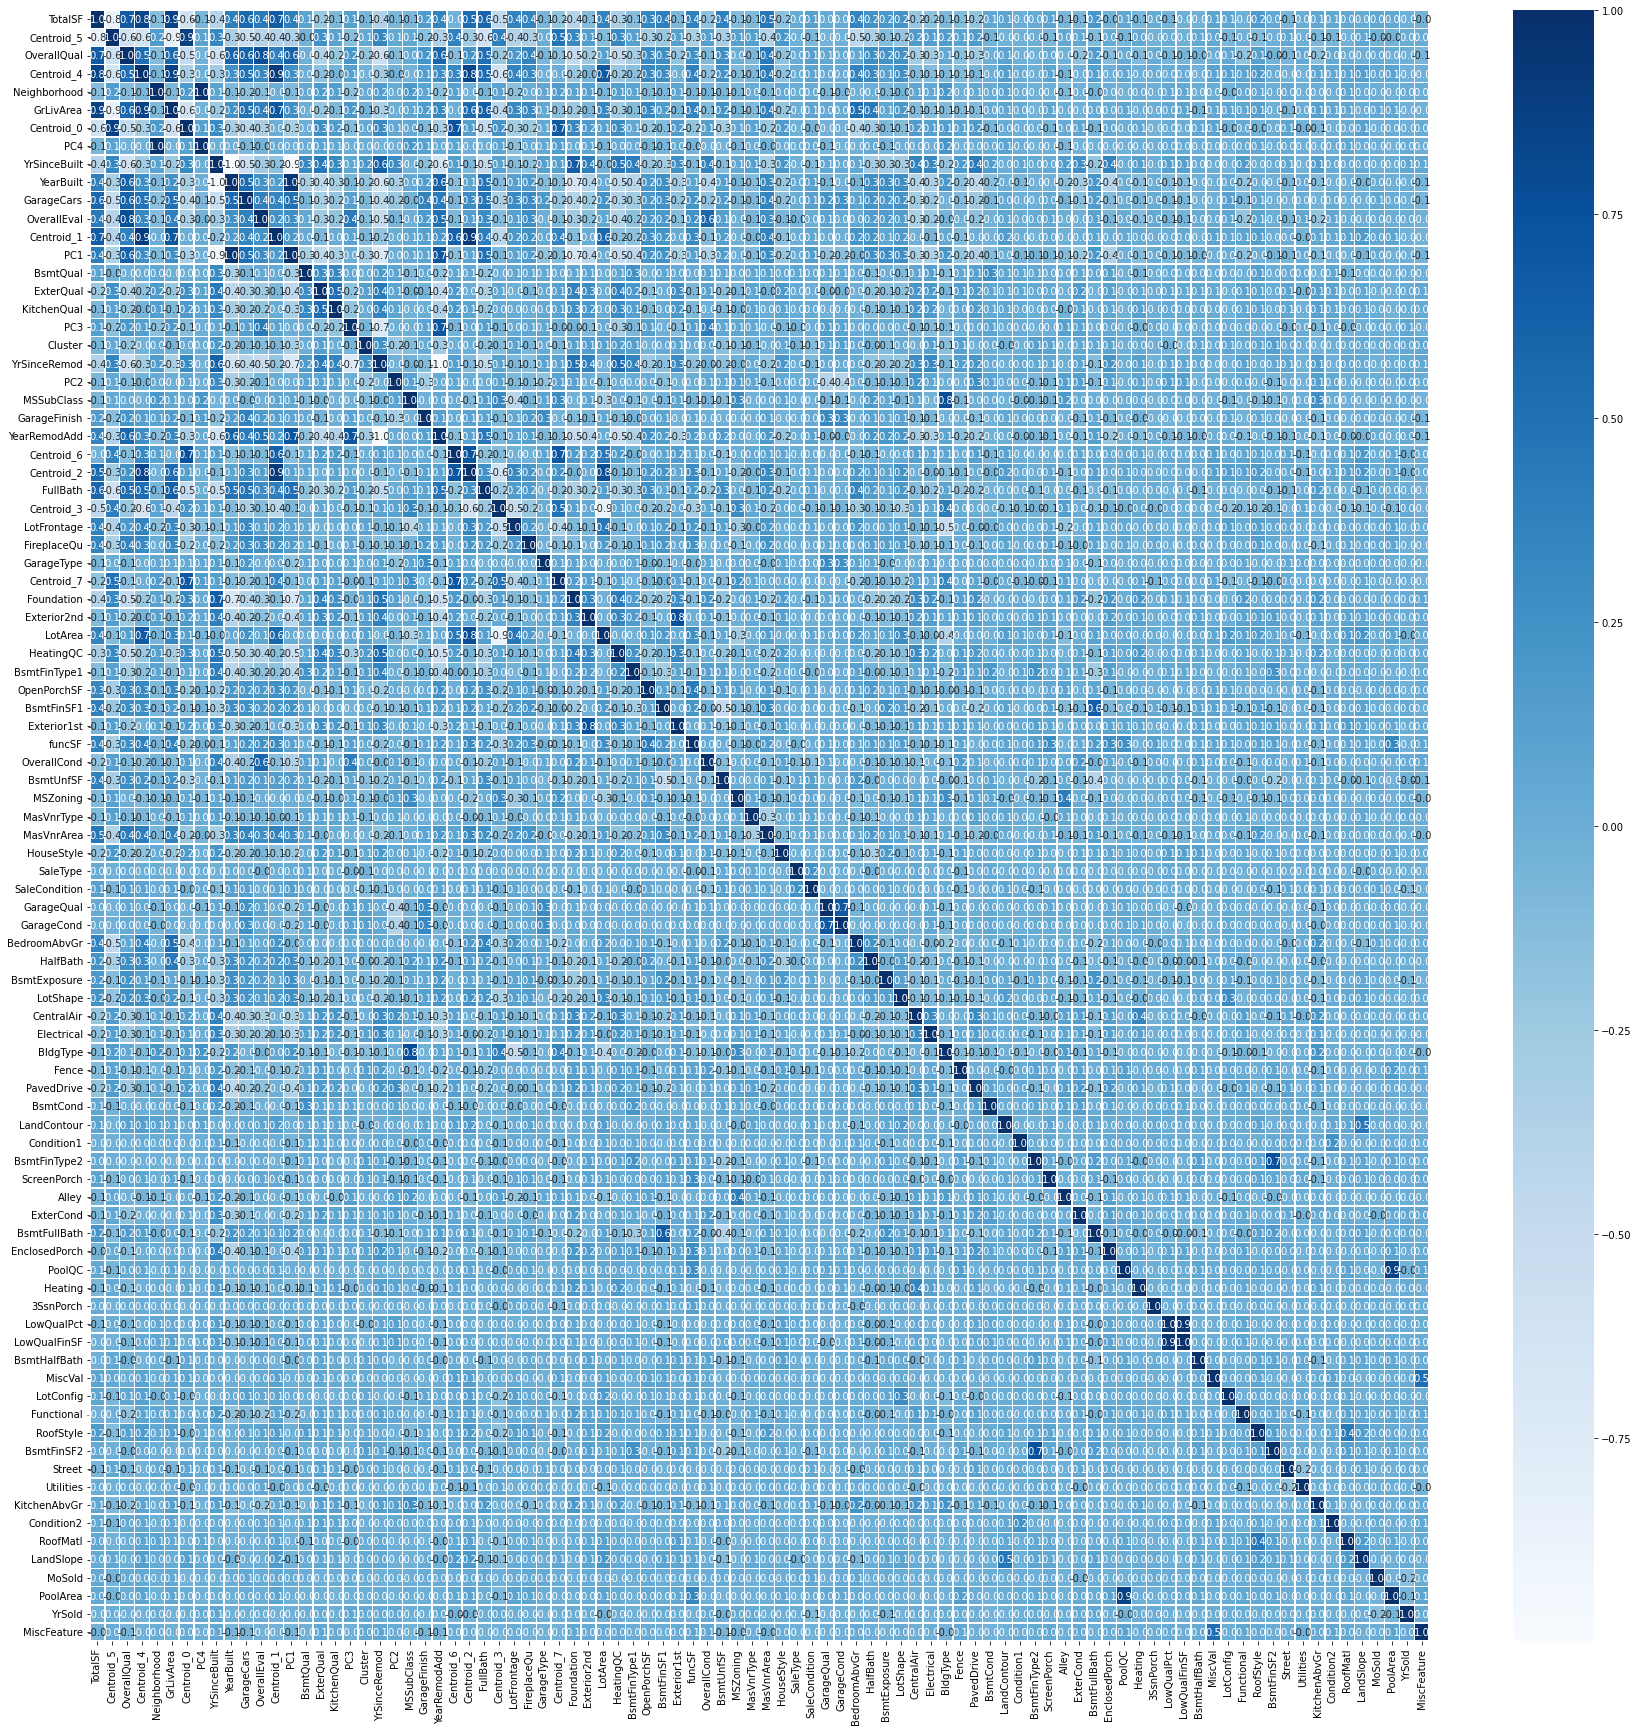

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

f,ax = plt.subplots(figsize=(30, 30))

sns.heatmap(X_full.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax, cmap='Blues')

### 8. 数值型特征对数变换+房价对数变换
#### 8.1. 可视化数值型特征分布
与房价类似，许多数值型的特征也不符合正态分布，我们通过可视化以及计算偏度，找出具有偏态分布的数值型特征，并进行对数变换  
借鉴知乎博主 @陈罐头

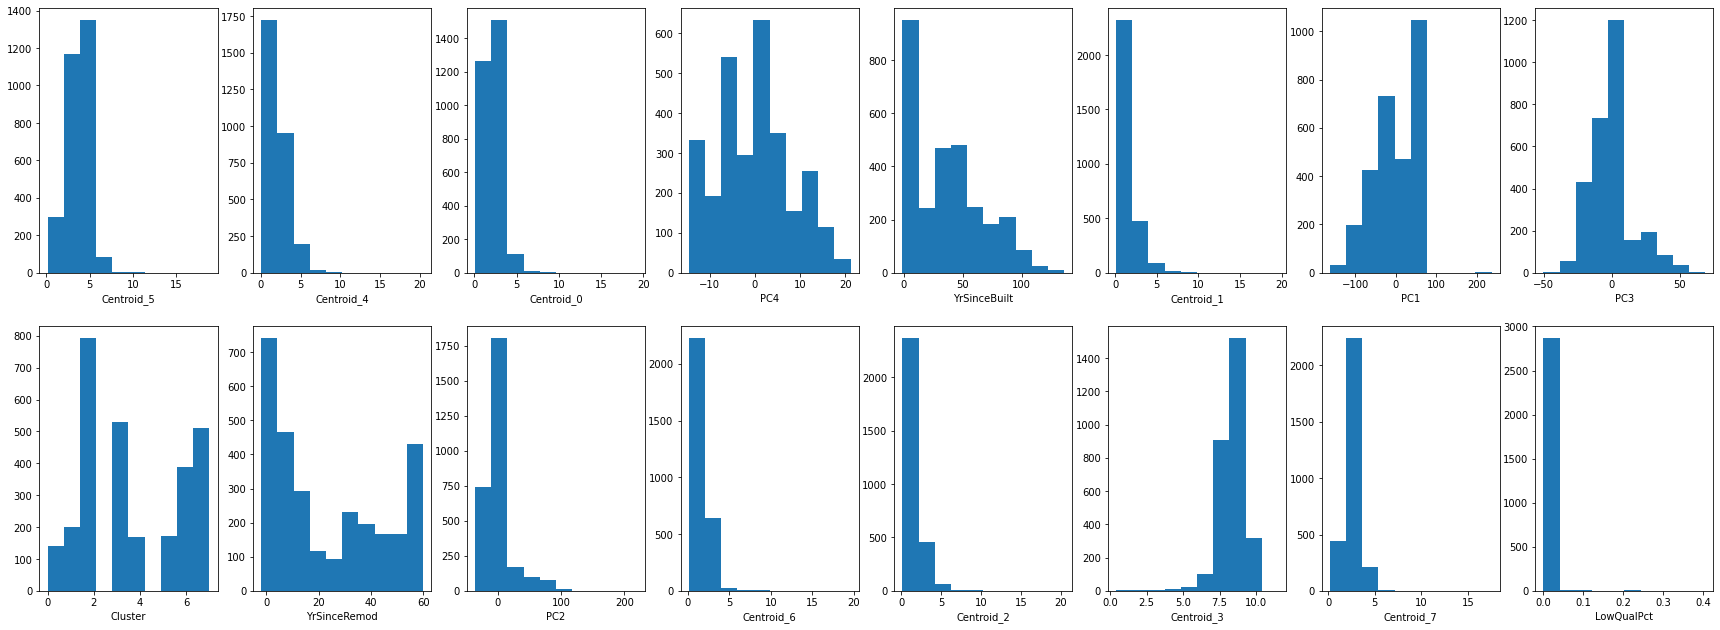

In [18]:
# 先将原来的类别型特征由int转为object
# 求出现在的类别型特征
object_cols = [cname for cname in X_full.columns if cname in object_cols]

# 将年份特征转为object类型（原为int型）
time_cols = ['YearBuilt','YearRemodAdd','YrSold','MoSold']
object_cols = object_cols + time_cols

# 求出现在的数值型特征
numerical_cols = [cname for cname in X_full.columns if (X_full[cname].dtype in ['int', 'float']) & (cname in selected_features_1) & (cname not in object_cols)]
fig = plt.figure(figsize=(30, 40))
for col in numerical_cols:
    ax = fig.add_subplot(7, 8, numerical_cols.index(col)+1)
    ax.set_xlabel(col)
    ax.hist(X_full[col])

#### 8.2. 计算数值型特征的偏度，对其进行对数变换

In [19]:
# 计算各数值型特征的偏度
skews = X_full[numerical_cols].skew()

# 对偏度绝对值大于0.5的特征进行对数变换
cols_need_log1p = skews[skews > 0.5].index.tolist()
for col in cols_need_log1p:
    if (col not in component_names) & (col not in ['YrSinceBuilt','YrSinceRemod']):
        X_full[col] = np.log1p(X_full[col])

Centroid_4       0.238987
Centroid_0      -0.194355
YrSinceBuilt     0.597022
Centroid_1       0.751450
PC3              0.878822
PC2              2.810055
Centroid_6       0.521365
Centroid_2       0.974370
Centroid_7      -0.322970
LowQualPct      11.332698
dtype: float64


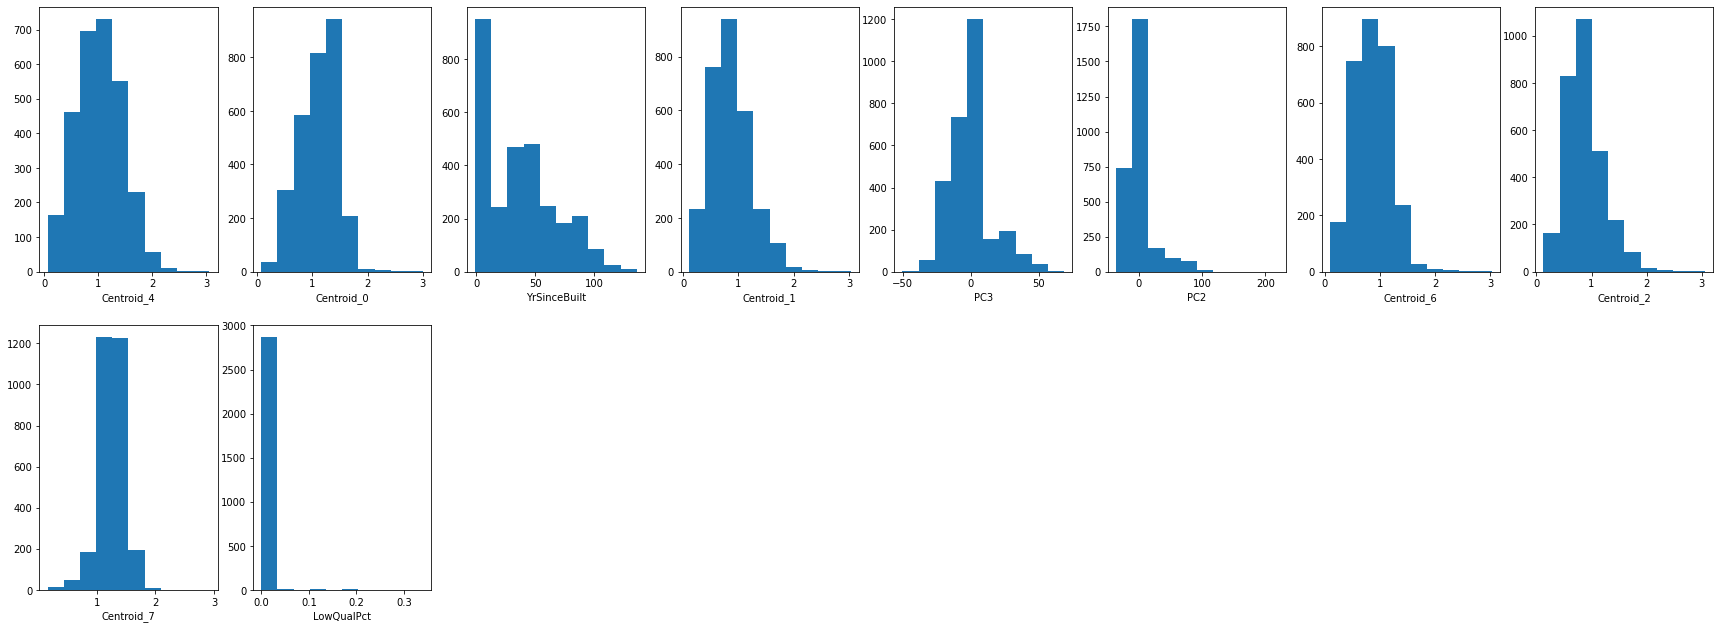

In [20]:
# 绘制对数变换后的特征分布
fig = plt.figure(figsize=(30, 40))
for col in cols_need_log1p:
    ax = fig.add_subplot(7, 8, cols_need_log1p.index(col)+1)
    ax.set_xlabel(col)
    ax.hist(X_full[col])
# 计算变换后各数值型特征的偏度
skews = X_full[cols_need_log1p].skew()
print(skews)

In [21]:
X_full.drop(['LowQualPct','PoolArea'], axis=1, inplace=True)

#### 8.4. 对SalePrice进行对数变换

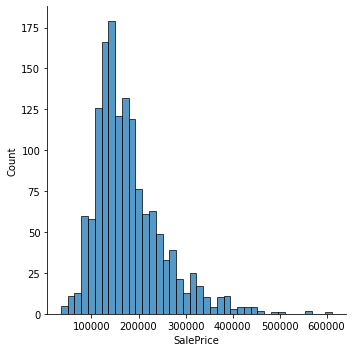

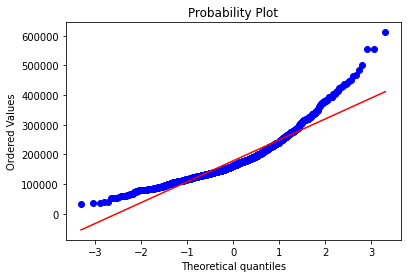

In [22]:
import scipy

# SalePrice目前是偏态分布
sns.displot(y_train_full)
fig = plt.figure()
res = scipy.stats.probplot(y_train_full, plot=plt)
# 红色线条表示正态分布，蓝色线条表示样本数据，蓝色越接近红色参考线，说明越符合预期分布

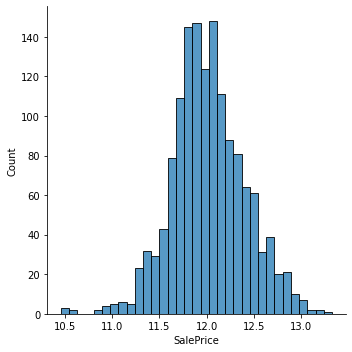

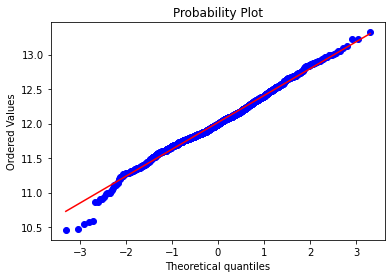

In [23]:
# 进行对数变换
y_train_full = np.log1p(y_train_full)

# 绘制分布图
sns.displot(y_train_full)
fig = plt.figure()
res = scipy.stats.probplot(y_train_full, plot=plt)

### 9. 划分训练集、验证集、测试集

In [24]:
X_train_full = X_full[:1444].copy()
X_test = X_full[1444:].copy()
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=1)

### 10. 多模型调参与融合
#### 10.1. 导包、定义交叉验证方式及基模型

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
# from sklearn.ensemble import RandomForestRegressor (效果不好)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

# 定义交叉验证模式
kf = KFold(n_splits=10, random_state=0, shuffle=True)

# 定义交叉验证误差
def cv_rmse(model):
    return np.sqrt(-1 * cross_val_score(model, X_train_full, y_train_full, scoring='neg_mean_squared_error', cv=kf))
# 定义均方根误差计算函数
def calc_rmse(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_pred, y_true))

# 实例化基模型
model_ridge = make_pipeline(RobustScaler(), RidgeCV(cv=kf, normalize=True))
model_lasso = make_pipeline(RobustScaler(), LassoCV(cv=kf, normalize=True, eps=0.0001, n_alphas=300))
model_svr = make_pipeline(RobustScaler(), SVR(C=15, epsilon= 0.0006, gamma=0.00045))  # 0.1164
model_gbr = GradientBoostingRegressor(n_estimators=6000,
                                      learning_rate=0.01,
                                      max_depth=4,
                                      max_features='sqrt',
                                      min_samples_leaf=15,
                                      min_samples_split=10,
                                      loss='huber',
                                      random_state=0)  # 0.1115
model_xgb = XGBRegressor(n_estimators=4000,
                         learning_rate=0.01,
                         max_depth=3,
                         subsample=0.6,
                         min_child_weight=3,
                         colsample_bytree=0.5,
                         n_jobs=-1,
                         random_state=0)  # 0.1131
model_cb = CatBoostRegressor(iterations=3000,
                             depth=6,
                             learning_rate=0.01,
                             loss_function='RMSE',
                             verbose = False,
                             random_state=0)  # 0.1119
model_lgb = LGBMRegressor(objective='regression',
                          n_estimators=3000,
                          learning_rate = 0.01,
                          max_depth=3,
                          num_leaves=30,
                          min_data_in_leaf=3,
                          max_bin=25,
                          bagging_fraction=0.6,
                          bagging_freq=11,
                          feature_fraction=0.6,
                          verbose=-1,
                          n_jobs=-1,
                          random_state=0)    # 0.1135

models = [model_gbr, model_xgb, model_cb, model_lgb]
model_names = ['gbr','xgb','cb','lgb']

In [ ]:
# 基线模型评估
scores = {}
for i, model in enumerate(models):
    score = cv_rmse(model)
    print('{} rmse score: {:.4f}, rmse std: {:.4f}'.format(model_names[i], score.mean(), score.std()))
    scores[model_names[i]] = (score.mean(), score.std())

#### 10.2. 模型融合——Stacking

In [26]:
# 定义StackingRegressor类
class StackingRegressor(object):
    def __init__(self, fir_models, fir_model_names, sec_model, cv):
        # 基模型
        self.fir_models = fir_models
        self.fir_model_names = fir_model_names
        # 第二层用来预测最终结果的模型
        self.sec_model = sec_model
        # 交叉验证模式，必须为k_fold对象
        self.cv = cv
    
    def fit_predict(self, X, y, test):
        # 初始化stacked_train、stacked_test
        stacked_train = pd.DataFrame()
        stacked_test = pd.DataFrame()
        # 初始化折数
        n_fold = 0
        # 遍历每个模型，做交叉验证
        for i, model in enumerate(self.fir_models):
            # stacked_train的各列存放每个模型的X预测值，每经过1折，填补1列中的某些行
            stacked_train[self.fir_model_names[i]] = np.zeros(X.shape[0])
            #遍历每一折交叉验证
            for train_index, valid_index in self.cv.split(X):
                n_fold += 1
                # stacked_test共有10x6列，第1个10列存放第1个模型在10折中对test的预测值
                stacked_test[self.fir_model_names[i] + '_' + str(n_fold)] = np.zeros(test.shape[0])
                # 划分数据集
                X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
                # 训练模型并预测结果
                model.fit(X_train, y_train)
                # 在1折中，填补stacked_train中某列的某些行；填补stacked_test的某1列
                stacked_train.loc[valid_index, self.fir_model_names[i]] = model.predict(X_valid) # 指定行号的访问只能用loc
                stacked_test.loc[:, self.fir_model_names[i] + '_' + str(n_fold)] = model.predict(test)
            print('{} is done.'.format(self.fir_model_names[i]))

        # 原来的y索引是乱的，现在将其整理好从0开始
        y.reset_index(drop=True, inplace=True)
        # stacked_train['y_true']存放X的真实值
        stacked_train['y_true'] = y

        # 计算每个模型对test的10轮（对应10折）预测结果的平均值
        # 循环结束后，stacked_test只剩6列[model_name]存放各模型对test的预测结果的均值
        for i, model_name in enumerate(self.fir_model_names):
            # 取stacked_test前10列，在列方向求均值，赋值给stacked_test[model_name] 
            stacked_test[model_name] = stacked_test.iloc[:, :10].mean(axis=1)
            # 每次用完这10列后将其原地删去，便于下次循环使用后10列
            stacked_test.drop(stacked_test.iloc[:, :10], axis=1, inplace=True)
        
        # 打印stacked_train和stacked_test
        print('----stacked_train----\n', stacked_train)
        print('----stacked_test----\n', stacked_test)
        
        # 用二层模型预测最终结果
        self.sec_model.fit(stacked_train.drop(columns='y_true'), stacked_train['y_true'])
        y_pred = self.sec_model.predict(stacked_test)
        return self.sec_model, y_pred

In [ ]:
# 实例化stacking回归预测器
sr = StackingRegressor(models, model_names, model_cb, kf)
# 返回二层模型及stacking的预测结果
sec_model, stacking_pred = sr.fit_predict(X_train, y_train, X_valid)
# 评估stacking的结果
stacking_score = calc_rmse(y_valid, stacking_pred)
print(stacking_score)

#### 10.3. 模型融合——Blending

In [ ]:
#sr = StackingRegressor(models, model_names, model_xgb, kf)
models = [model_gbr, model_xgb, model_cb, model_lgb, sr]

# 计算各模型的预测结果
def calc_scores(models, sr, testdata, stacking_pred):
    # scores存放各模型的预测结果
    scores = []
    for model in models:
        if model == sr:
            model_pred = stacking_pred  # stacking_pred
        else:
            model.fit(X_train, y_train)
            model_pred = model.predict(testdata)
        scores.append(model_pred)
    # 计算总预测值
    return scores

# 计算blending结果
def calc_blending_score(scores, weights):
    blending_score = 0.0
    for score, weight in zip(scores, weights):
        blending_score += score * weight
    return  blending_score

In [ ]:
# 衡量验证集的blending误差
weights = [0.10, 0.15, 0.15, 0.10, 0.5]
scores = calc_scores(models, sr, X_valid, stacking_pred)
blending_rmse = calc_rmse(y_valid, calc_blending_score(scores, weights))
print(blending_rmse) # 0.1099

### 11. 预测测试集

In [ ]:
# 预测并提交结果
sec_model, stacking_pred = sr.fit_predict(X_train_full, y_train_full, X_test)
scores = calc_scores(models, sr, X_test, stacking_pred)
final_pred = np.exp(calc_blending_score(scores, weights)) - 1
final_pred

### 12. 提交结果

In [ ]:
# 写入提交文件
output = pd.DataFrame({'Id': X_test.index + 17,'SalePrice': final_pred})
output.to_csv('submission.csv', index=False)